---

## Model Ensemble

---

In [79]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import logging

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.exceptions import NotFittedError
from sklearn.metrics import silhouette_score#, make_scorer
#from sklearn.model_selection import GridSearchCV

from yellowbrick.cluster import SilhouetteVisualizer

from scipy.cluster.hierarchy import dendrogram, linkage

In [80]:
# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_dataset(file_path):
    """Load a dataset from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        logging.info("Dataset loaded correctly.")
        return df
    except Exception as e:
        logging.error(f"Error loading the dataset: {e}")
        return None

def preprocess_data(df, predictor_columns):
    """Preprocesses data, applying appropriate transformations."""
    try:
        if not all(col in df.columns for col in predictor_columns):
            raise ValueError("Some specified columns do not exist in the dataset.")
        
        X = df[predictor_columns]
        
        categorical_cols = X.select_dtypes(include=['object']).columns
        numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
        
        transformer = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ]
        )
        
        return X, transformer
    except Exception as e:
        logging.error(f"Error in data preprocessing: {e}")
        return None, None

In [81]:
# K-means
def train_kmeans(X, transformer, n_clusters=3, item_id=None, original_df=None, ranking_column=None):
    """It trains a KMeans model to classify inventories and displays relevant metrics."""
    try:
        #------------------------------------------------------
            # Pipeline Model
        #------------------------------------------------------
        pipeline = Pipeline([
            ('preprocessor', transformer),
            ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
        ])

        km = pipeline.fit(X)

        kmeans = km.named_steps['kmeans']
        X_transformed = km.named_steps['preprocessor'].transform(X)
        #------------------------------------------------------



        #------------------------------------------------------
            # Metrics
        #------------------------------------------------------
        silhouette_avg = silhouette_score(X_transformed, kmeans.labels_)
        # inertia = kmeans.inertia_
        # cohesion = np.mean([np.linalg.norm(X_transformed[i] - kmeans.cluster_centers_[kmeans.labels_[i]]) for i in range(len(X_transformed))])
        # inter_cluster_dist = np.mean([np.linalg.norm(c1 - c2) for i, c1 in enumerate(kmeans.cluster_centers_) for c2 in kmeans.cluster_centers_[i+1:]])

        logging.info("\n<<< Start :: Inventory Classification :: KMeans >>>")
        logging.info(f"Model Parameters: {kmeans.get_params()}")
        logging.info(f"Silhouette Score: {silhouette_avg:.4f}")
        # logging.info(f"Inercia intra-clúster: {inertia:.2f}")
        # logging.info(f"Cohesión intra-clúster: {cohesion:.2f}")
        # logging.info(f"Distancia media entre clústeres: {inter_cluster_dist:.2f}")
        #------------------------------------------------------



        #------------------------------------------------------
            # Tagging clusters as classes A, B, C
        #------------------------------------------------------
        cluster_labels = kmeans.labels_
        df_result = X.copy()
        df_result['TAG_KM'] = cluster_labels
        df_result['SIL_KM'] = silhouette_avg

        # Ranking column
        if ranking_column and original_df is not None and ranking_column in original_df.columns:
            df_result[ranking_column] = original_df[ranking_column].values
            cluster_sum = df_result.groupby('TAG_KM')[ranking_column].sum().sort_values(ascending=False)
        else:
            logging.warning("No valid column was specified for sorting. Cluster size will be used.")
            cluster_sum = df_result.groupby('TAG_KM').size().sort_values(ascending=False)

        # Assign A, B, C
        cluster_to_label = {cluster: chr(65 + i) for i, cluster in enumerate(cluster_sum.index)}
        df_result['TAG_KM'] = df_result['TAG_KM'].map(cluster_to_label)

        if item_id and original_df is not None and item_id in original_df.columns:
            df_result[item_id] = original_df[item_id].values

        # Count
        label_counts = df_result['TAG_KM'].value_counts().sort_index()
        label_percentages = (label_counts / label_counts.sum()) * 100

        logging.info("\n<<< Results :: Inventory Classification :: KMeans >>>")
        for cluster in label_counts.index:
            count = label_counts[cluster]
            percentages = label_percentages[cluster]
            logging.info(f"  > Class {cluster}: {count} items ({percentages:.2f}%)")
        #------------------------------------------------------



        #------------------------------------------------------
            # Image: Silhouette Score
        #------------------------------------------------------
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
        visualizer.fit(X_transformed)
        visualizer.show()
        #------------------------------------------------------



        return km, df_result, X_transformed
    
    except NotFittedError:
        logging.error("Error: Model fitting.")
    except Exception as e:
        logging.error(f"Error in Training :: KMeans :: {e}")
    return None, None, None

In [82]:
# Hierarchical
def train_hierarchical(X, transformer, n_clusters=3, item_id=None, original_df=None, ranking_column=None):
    """It trains a Hierarchical Clustering model to classify inventories and displays relevant metrics."""
    try:
        #------------------------------------------------------
            # Pipeline Model
        #------------------------------------------------------
        pipeline = Pipeline([
            ('preprocessor', transformer)
        ])

        X_transformed = pipeline.fit_transform(X)

        hc = AgglomerativeClustering(n_clusters=n_clusters)
        labels = hc.fit_predict(X_transformed)
        #------------------------------------------------------



        #------------------------------------------------------
            # Metrics
        #------------------------------------------------------
        silhouette_avg = silhouette_score(X_transformed, labels)


        logging.info("\n<<< Start :: Inventory Classification :: Hierarchical Clustering >>>")
        logging.info(f"Model Parameters: {hc.get_params()}")
        logging.info(f"Silhouette Score: {silhouette_avg:.4f}")
        #------------------------------------------------------



        #------------------------------------------------------
            # Tagging clusters as classes A, B, C
        #------------------------------------------------------
        df_result = X.copy()
        df_result['TAG_HC'] = labels
        df_result['SIL_HC'] = silhouette_avg

        # Ranking column
        if ranking_column and original_df is not None and ranking_column in original_df.columns:
            df_result[ranking_column] = original_df[ranking_column].values
            cluster_sum = df_result.groupby('TAG_HC')[ranking_column].sum().sort_values(ascending=False)
        else:
            logging.warning("No valid column was specified for sorting. Cluster size will be used.")
            cluster_sum = df_result.groupby('TAG_HC').size().sort_values(ascending=False)

        # Assign A, B, C
        cluster_to_label = {cluster: chr(65 + i) for i, cluster in enumerate(cluster_sum.index)}
        df_result['TAG_HC'] = df_result['TAG_HC'].map(cluster_to_label)

        if item_id and original_df is not None and item_id in original_df.columns:
            df_result[item_id] = original_df[item_id].values

        # Count
        label_counts = df_result['TAG_HC'].value_counts().sort_index()
        label_percentages = (label_counts / label_counts.sum()) * 100

        logging.info("\n<<< Results :: Inventory Classification :: Hierarchical Clustering >>>")
        for cluster in label_counts.index:
            count = label_counts[cluster]
            percentages = label_percentages[cluster]
            logging.info(f"  > Class {cluster}: {count} items ({percentages:.2f}%)")
        #------------------------------------------------------



        #------------------------------------------------------
            # Image: Dendrogram
        #------------------------------------------------------
        Z = linkage(X_transformed, method=hc.get_params()['linkage'])
        plt.figure(figsize=(10, 5))
        dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=12., show_contracted=True)
        plt.title('Dendrogram')
        plt.xlabel('Items')
        plt.ylabel('Distance')
        plt.tight_layout()
        plt.show()
        #------------------------------------------------------



        #------------------------------------------------------
            # Image: Silhouette Score
        #------------------------------------------------------
        dummy_model = KMeans(n_clusters=n_clusters)
        dummy_model.fit(X_transformed)
        dummy_model.labels_ = labels

        visualizer = SilhouetteVisualizer(dummy_model, colors='yellowbrick')
        visualizer.fit(X_transformed)
        visualizer.show()
        #------------------------------------------------------



        return hc, df_result, X_transformed
    
    except Exception as e:
        logging.error(f"Error in Training :: Hierarchical Clustering :: {e}")
    return None, None, None

In [83]:
# GMM
def train_gmm(X, transformer, n_clusters=3, item_id=None, original_df=None, ranking_column=None):
    """It trains a Gaussian Mixture model to classify inventories and displays relevant metrics."""
    try:
        #------------------------------------------------------
            # Pipeline Model
        #------------------------------------------------------
        pipeline = Pipeline([
            ('preprocessor', transformer)
        ])

        X_transformed = pipeline.fit_transform(X)
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm.fit(X_transformed)
        labels = gmm.predict(X_transformed)
        #------------------------------------------------------



        #------------------------------------------------------
            # Metrics
        #------------------------------------------------------
        silhouette_avg = silhouette_score(X_transformed, labels)

        logging.info("\n<<< Start :: Inventory Classification :: GMM >>>")
        logging.info(f"Model Parameters: {gmm.get_params()}")
        logging.info(f"Silhouette Score: {silhouette_avg:.4f}")
        #------------------------------------------------------



        #------------------------------------------------------
            # Tagging clusters as classes A, B, C
        #------------------------------------------------------
        df_result = X.copy()
        df_result['TAG_GMM'] = labels
        df_result['SIL_GMM'] = silhouette_avg

        # Ranking column
        if ranking_column and ranking_column in original_df.columns:
            df_result[ranking_column] = original_df[ranking_column].values
            cluster_sum = df_result.groupby('TAG_GMM')[ranking_column].sum().sort_values(ascending=False)
        else:
            logging.warning("No valid column was specified for sorting. Cluster size will be used.")
            cluster_sum = df_result.groupby('TAG_GMM').size().sort_values(ascending=False)

        # Assign A, B, C
        cluster_to_label = {cluster: chr(65 + i) for i, cluster in enumerate(cluster_sum.index)}
        df_result['TAG_GMM'] = df_result['TAG_GMM'].map(cluster_to_label)

        if item_id and item_id in original_df.columns:
            df_result[item_id] = original_df[item_id].values

        # Count
        label_counts = df_result['TAG_GMM'].value_counts().sort_index()
        label_percentages = (label_counts / label_counts.sum()) * 100

        logging.info("\n<<< Results :: Inventory Classification :: GMM >>>")
        for cluster in label_counts.index:
            count = label_counts[cluster]
            percentages = label_percentages[cluster]
            logging.info(f"  > Class {cluster}: {count} items ({percentages:.2f}%)")
        #------------------------------------------------------



        #------------------------------------------------------
            # Image: Silhouette Score
        #------------------------------------------------------
        dummy_model = KMeans(n_clusters=n_clusters)
        dummy_model.fit(X_transformed)
        dummy_model.labels_ = labels

        visualizer = SilhouetteVisualizer(dummy_model, colors='yellowbrick')
        visualizer.fit(X_transformed)
        visualizer.show()
        #------------------------------------------------------



        return gmm, df_result, X_transformed

    except Exception as e:
        logging.error(f"Error in Training :: GMM :: {e}")
    return None, None, None

In [84]:
# ABC
def train_abc(df, ranking_column, item_id=None):
    logging.info("\n<<< Start :: Inventory Classification :: ABC >>>")
    try:
        if ranking_column not in df.columns:
            raise ValueError("No valid column was specified for sorting.")
        
        if item_id and item_id not in df.columns:
            raise ValueError("Not existing item_id column.")

        df_abc = df.sort_values(by=ranking_column, ascending=False).reset_index(drop=True)
        df_abc['cum_pct'] = df_abc[ranking_column].cumsum() / df_abc[ranking_column].sum()

        def classify(p):
            if p <= 0.80:
                return 'A'
            elif p <= 0.95:
                return 'B'
            else:
                return 'C'

        df_abc['TAG_ABC'] = df_abc['cum_pct'].apply(classify)

        logging.info("\n<<< Results :: Inventory Classification :: ABC >>>")
        class_counts = df_abc['TAG_ABC'].value_counts().sort_index()
        for cls in ['A', 'B', 'C']:
            count = class_counts.get(cls, 0)
            pct = (count / len(df_abc)) * 100
            logging.info(f"  > Class {cls}: {count} items ({pct:.2f}%)")

        plt.figure(figsize=(10, 6))
        plt.plot(df_abc['cum_pct'].values, marker='o', label='% Cum')
        plt.axhline(0.80, color='r', linestyle='--', label='80% (Class A)')
        plt.axhline(0.95, color='g', linestyle='--', label='95% (Class B)')
        plt.title('ABC - Pareto')
        plt.xlabel('Items')
        plt.ylabel(f'% Cum of {ranking_column}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ---------------------------
        # Silhouette Score
        # ---------------------------
        try:
            X = df_abc[[ranking_column]].values
            X_scaled = StandardScaler().fit_transform(X)
            labels = df_abc['TAG_ABC'].map({'A': 0, 'B': 1, 'C': 2}).values

            if len(set(labels)) > 1:
                silhouette_avg = silhouette_score(X_scaled, labels)
                logging.info(f"Silhouette Score: {silhouette_avg:.4f}")
                df_abc['SIL_ABC'] = silhouette_avg  # opcional: guardar en df
            else:
                logging.warning("Silhouette Score no calculado: solo hay una clase.")

        except Exception as e:
            logging.warning(f"No se pudo calcular el coeficiente de silueta: {e}")

        return df_abc

    except Exception as e:
        logging.error(f"Error in Training :: ABC :: {e}")
        return None

In [85]:
#------------------------------------------------------
    # Set Parameters
#------------------------------------------------------
dataset_path = "test.csv"
predictor_columns = ["UNITS", "ORDERS", "LEAD_TIME_DAYS", "AVG_STOCK_LEVEL"]

tags = 3
item_id = "PRODUCT_ID"
ranking_column = "SALES"
#------------------------------------------------------
df = load_dataset(dataset_path)

2025-11-02 22:03:21,023 - INFO - Dataset loaded correctly.


2025-11-02 22:03:21,934 - INFO - 
<<< Start :: Inventory Classification :: KMeans >>>
2025-11-02 22:03:21,935 - INFO - Model Parameters: {'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 'auto', 'random_state': 42, 'tol': 0.0001, 'verbose': 0}
2025-11-02 22:03:21,935 - INFO - Silhouette Score: 0.7250
2025-11-02 22:03:21,940 - INFO - 
<<< Results :: Inventory Classification :: KMeans >>>
2025-11-02 22:03:21,940 - INFO -   > Class A: 7475 items (92.67%)
2025-11-02 22:03:21,941 - INFO -   > Class B: 560 items (6.94%)
2025-11-02 22:03:21,942 - INFO -   > Class C: 31 items (0.38%)


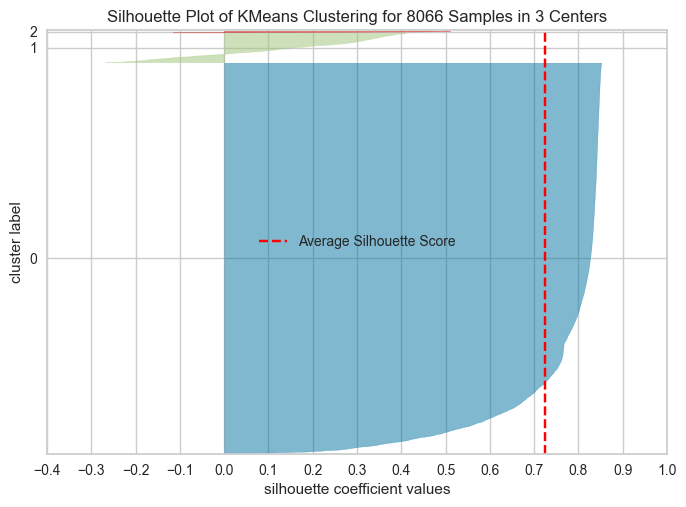

2025-11-02 22:03:23,661 - INFO - 
<<< Done :: Inventory Classification :: KMeans >>>


8066
UNITS              8066
ORDERS             8066
LEAD_TIME_DAYS     8066
AVG_STOCK_LEVEL    8066
TAG_KM             8066
SIL_KM             8066
SALES              8066
PRODUCT_ID         8066
dtype: int64


In [86]:
if df is not None:
    X, transformer = preprocess_data(df, predictor_columns)
    if X is not None and transformer is not None:
        km, df_km, X_transformed = train_kmeans(X, transformer, tags, item_id, df, ranking_column)
        if km:
            logging.info("\n<<< Done :: Inventory Classification :: KMeans >>>")
            print(len(X_transformed))
            print(df_km.count())

2025-11-02 22:03:25,905 - INFO - 
<<< Start :: Inventory Classification :: Hierarchical Clustering >>>
2025-11-02 22:03:25,908 - INFO - Model Parameters: {'compute_distances': False, 'compute_full_tree': 'auto', 'connectivity': None, 'distance_threshold': None, 'linkage': 'ward', 'memory': None, 'metric': 'euclidean', 'n_clusters': 3}
2025-11-02 22:03:25,910 - INFO - Silhouette Score: 0.8680
2025-11-02 22:03:25,915 - INFO - 
<<< Results :: Inventory Classification :: Hierarchical Clustering >>>
2025-11-02 22:03:25,916 - INFO -   > Class A: 7946 items (98.51%)
2025-11-02 22:03:25,916 - INFO -   > Class B: 68 items (0.84%)
2025-11-02 22:03:25,917 - INFO -   > Class C: 52 items (0.64%)


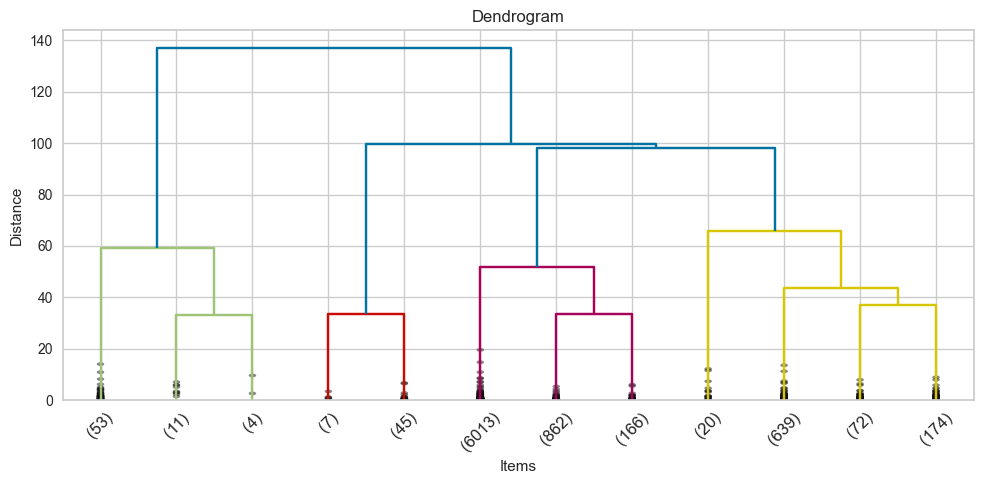

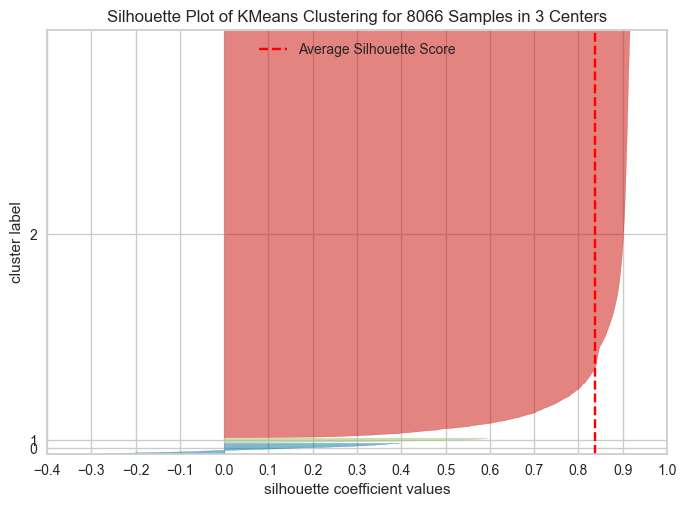

2025-11-02 22:03:30,919 - INFO - 
<<< Done :: Inventory Classification :: Hierarchical Clustering >>>


8066
UNITS              8066
ORDERS             8066
LEAD_TIME_DAYS     8066
AVG_STOCK_LEVEL    8066
TAG_HC             8066
SIL_HC             8066
SALES              8066
PRODUCT_ID         8066
dtype: int64


In [87]:
if df is not None:
    X, transformer = preprocess_data(df, predictor_columns)
    if X is not None and transformer is not None:
        hc, df_hc, X_transformed = train_hierarchical(X, transformer, tags, item_id, df, ranking_column)
        if hc:
            logging.info("\n<<< Done :: Inventory Classification :: Hierarchical Clustering >>>")
            print(len(X_transformed))
            print(df_hc.count())

2025-11-02 22:03:31,855 - INFO - 
<<< Start :: Inventory Classification :: GMM >>>
2025-11-02 22:03:31,855 - INFO - Model Parameters: {'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 100, 'means_init': None, 'n_components': 3, 'n_init': 1, 'precisions_init': None, 'random_state': 42, 'reg_covar': 1e-06, 'tol': 0.001, 'verbose': 0, 'verbose_interval': 10, 'warm_start': False, 'weights_init': None}
2025-11-02 22:03:31,855 - INFO - Silhouette Score: 0.1746
2025-11-02 22:03:31,855 - INFO - 
<<< Results :: Inventory Classification :: GMM >>>
2025-11-02 22:03:31,855 - INFO -   > Class A: 3650 items (45.25%)
2025-11-02 22:03:31,855 - INFO -   > Class B: 1062 items (13.17%)
2025-11-02 22:03:31,855 - INFO -   > Class C: 3354 items (41.58%)


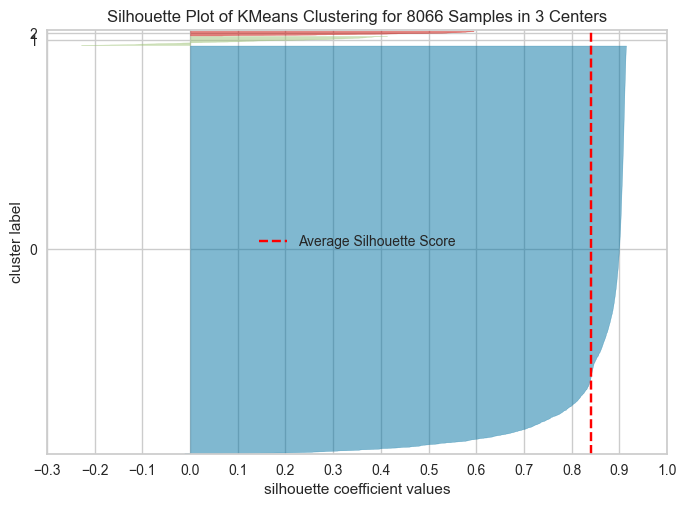

2025-11-02 22:03:33,537 - INFO - 
<<< Done :: Inventory Classification :: GMM >>>


8066
UNITS              8066
ORDERS             8066
LEAD_TIME_DAYS     8066
AVG_STOCK_LEVEL    8066
TAG_GMM            8066
SIL_GMM            8066
SALES              8066
PRODUCT_ID         8066
dtype: int64


In [88]:
if df is not None:
    X, transformer = preprocess_data(df, predictor_columns)
    if X is not None and transformer is not None:
        gmm, df_gmm, X_transformed = train_gmm(X, transformer, tags, item_id, df, ranking_column)
        if gmm:
            logging.info("\n<<< Done :: Inventory Classification :: GMM >>>")
            print(len(X_transformed))
            print(df_gmm.count())

In [89]:
# Merge
df = df_gmm.merge(df_km[['PRODUCT_ID', 'TAG_KM', 'SIL_KM']], on='PRODUCT_ID', how='left')

df = df.merge(df_hc[['PRODUCT_ID', 'TAG_HC', 'SIL_HC']], on='PRODUCT_ID', how='left')

In [90]:
df.count()

UNITS              8066
ORDERS             8066
LEAD_TIME_DAYS     8066
AVG_STOCK_LEVEL    8066
TAG_GMM            8066
SIL_GMM            8066
SALES              8066
PRODUCT_ID         8066
TAG_KM             8066
SIL_KM             8066
TAG_HC             8066
SIL_HC             8066
dtype: int64

In [91]:
df.head()

,UNITS,ORDERS,LEAD_TIME_DAYS,AVG_STOCK_LEVEL,TAG_GMM,SIL_GMM,SALES,PRODUCT_ID,TAG_KM,SIL_KM,TAG_HC,SIL_HC
0,76,58,15.00,3.62,C,0.17456,197,2125140685,A,0.725029,A,0.868013
1,250,231,0.75,2.24,A,0.17456,1378,333003193,A,0.725029,A,0.868013
2,154,158,3.25,3.68,C,0.17456,875,2121882098,A,0.725029,A,0.868013
3,143,157,1.40,2.43,A,0.17456,776,2124431789,A,0.725029,A,0.868013
4,66,69,2.00,3.19,C,0.17456,445,2123778029,A,0.725029,A,0.868013


In [92]:
order_by = ['PRODUCT_ID', 'TAG_GMM', 'TAG_KM', 'TAG_HC', 'SIL_GMM', 'SIL_KM', 'SIL_HC'] + predictor_columns

df = df[order_by]

In [93]:
df.head()

,PRODUCT_ID,TAG_GMM,TAG_KM,TAG_HC,SIL_GMM,SIL_KM,SIL_HC,UNITS,ORDERS,LEAD_TIME_DAYS,AVG_STOCK_LEVEL
0,2125140685,C,A,A,0.17456,0.725029,0.868013,76,58,15.00,3.62
1,333003193,A,A,A,0.17456,0.725029,0.868013,250,231,0.75,2.24
2,2121882098,C,A,A,0.17456,0.725029,0.868013,154,158,3.25,3.68
3,2124431789,A,A,A,0.17456,0.725029,0.868013,143,157,1.40,2.43
4,2123778029,C,A,A,0.17456,0.725029,0.868013,66,69,2.00,3.19


In [94]:
len(X_transformed)

8066

## Weighted Vote

In [95]:
df_weighted_vote = df.copy()

In [96]:
df_weighted_vote.count()

PRODUCT_ID         8066
TAG_GMM            8066
TAG_KM             8066
TAG_HC             8066
SIL_GMM            8066
SIL_KM             8066
SIL_HC             8066
UNITS              8066
ORDERS             8066
LEAD_TIME_DAYS     8066
AVG_STOCK_LEVEL    8066
dtype: int64

In [97]:
def weighted_vote(row):
    votes = [
        (row['TAG_GMM'], row['SIL_GMM']),
        (row['TAG_KM'], row['SIL_KM']),
        (row['TAG_HC'], row['SIL_HC']),
    ]
    # Group by tag and sum the weights
    pesos_por_tag = {}
    for tag, weight in votes:
        pesos_por_tag[tag] = pesos_por_tag.get(tag, 0) + weight
    # Pick the tag with the highest weight
    return max(pesos_por_tag.items(), key=lambda x: x[1])[0]

df_weighted_vote['TAG_FINAL'] = df.apply(weighted_vote, axis=1)

In [98]:
le = LabelEncoder()
final_labels = le.fit_transform(df_weighted_vote['TAG_FINAL'])
silhouette_final = silhouette_score(X_transformed, final_labels)
print(f"Final Silhouette Score: {silhouette_final:.4f}")

Final Silhouette Score: 0.7574


## ABC

In [99]:
if df is not None:
    df_abc = train_abc(df, ranking_column, item_id)
    if df_abc is not None:
        logging.info("\n<<< Done :: Inventory Classification :: ABC >>>")

2025-11-02 22:03:34,664 - INFO - 
<<< Start :: Inventory Classification :: ABC >>>
2025-11-02 22:03:34,665 - ERROR - Error in Training :: ABC :: No valid column was specified for sorting.
